# Prepare Data for Modelling (Data Splits, including thresholding and PCA)
The current notebook is used to create datasets that can be used for modelling. Updated 21st of May!

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pickle as pkl
from sklearn import datasets
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
# !pip install scikit-bio
import skbio
from skbio.stats.composition import clr
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from skbio.stats.composition import closure, clr
from scipy.stats import gmean
from sklearn.preprocessing import StandardScaler



# Backup: healthy or diseased?

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_80823/1954401907.py:9: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df_with_meta = pd.read_csv(full)


(8261, 1584)
study_condition
control                      5620
CRC                           701
IBD                           627
IGT                           288
adenoma                       209
cirrhosis                     123
AS                             95
melanoma                       86
T2D                            83
schizophrenia                  81
STH                            77
ME/CFS                         50
migraine                       49
carcinoma_surgery_history      40
cephalosporins                 36
CDI                            33
asthma                         24
BD                             20
T1D                            19
Name: count, dtype: int64
Cumulative explained variance is: [0.137917   0.23582501 0.28646852 0.32070565 0.34711498 0.36853905
 0.38878716 0.40516462 0.42082084 0.43555006 0.44997325 0.46316434
 0.47593354 0.48817369 0.50000084 0.51152385 0.5227192  0.53368371
 0.54456363 0.55496441 0.56529864 0.5753856  0.58520023 0.594986

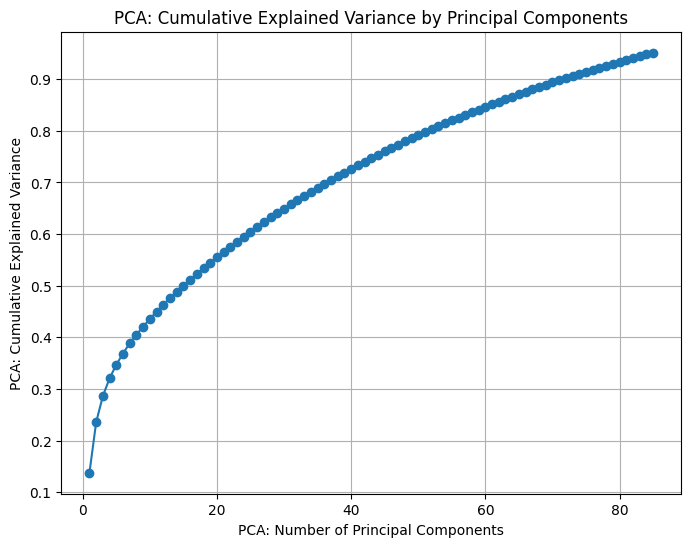

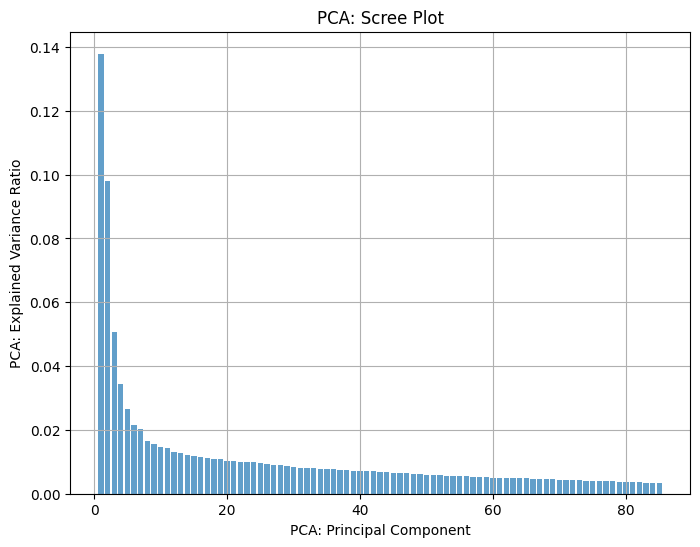

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

# Load data
root = Path.cwd().parents[1]
full = root / "data" / "raw" / "full_df_with_meta.csv"
full_df_with_meta = pd.read_csv(full)

# Get shape of full_df_with_meta
print(full_df_with_meta.shape)  # (8261,1581)
print(full_df_with_meta['study_condition'].value_counts())  # 5620 healthy controls, 2641 patients

# Make a new column called 'healthy' that is 1 if study_condition == control, 0 if study_condition is not control
full_df_with_meta['healthy'] = np.where(full_df_with_meta["study_condition"] == "control", 1, 0)

# Define all bacteria columns as containing the string "|"
bacteria_columns = [col for col in full_df_with_meta.columns if '|' in col]

# Split data into features (X) and target (y)
X = full_df_with_meta[bacteria_columns]
y = full_df_with_meta['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Perform PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_filtered)
X_val_pca = pca.transform(X_val_filtered)
X_test_pca = pca.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA: Scree Plot')
plt.grid(True)
plt.show()

# Save the PCA-transformed data
datasets = {
    'Training set': (X_train_pca, y_train), 
    'Validation set': (X_val_pca, y_val), 
    'Test set': (X_test_pca, y_test)
}
output_dir = root / 'data' / 'backup'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)

In [20]:
test_train_df = pd.read_csv("/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/data/backup/train.csv")
display(test_train_df)

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,healthy
0,15.335609,0.168854,-10.425782,9.220834,-15.324080,-2.032690,11.929195,0.668881,1.271370,5.863247,...,0.886526,3.802861,1.665949,0.983289,2.054801,-1.619736,2.623834,0.467153,-0.653407,1
1,-47.380825,11.189375,0.068704,13.625587,-16.445101,-3.168642,1.804137,-2.035083,1.624256,-1.901567,...,-2.700555,-3.052452,2.324415,-6.347923,-2.241384,-2.611734,5.645003,-0.606577,0.318893,1
2,14.994632,-6.385274,0.142130,10.628699,10.754565,6.128175,0.625204,-9.706662,16.699554,5.745339,...,-1.460693,-2.153053,6.083171,1.707912,0.580075,-0.072633,2.551194,4.470582,-2.903715,1
3,6.995190,8.731679,-17.681398,-4.206435,2.877928,-4.321915,11.399626,8.459340,2.806949,-1.494642,...,-3.830003,-0.863743,-6.853897,8.247128,-2.198782,-5.082373,3.802748,-2.821106,5.458370,1
4,17.517681,6.487387,13.109617,-2.394950,-9.225139,-9.972625,-15.318365,10.885839,10.292642,-4.991914,...,5.983879,2.217502,-1.910215,-3.894647,0.226425,3.474638,-4.438436,1.161741,0.727219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5776,11.116484,3.211662,-24.913036,-8.605178,-0.070728,-5.456086,7.970823,1.265372,-4.867541,-5.138607,...,0.836989,4.723423,1.658841,3.064386,-2.992043,-1.616614,-2.896571,1.432011,0.331523,1
5777,20.981867,-1.109568,-8.123310,9.336628,2.101148,1.392975,-2.642913,-4.543113,-1.109800,7.038485,...,2.588800,-1.731309,0.952642,-0.870846,2.878559,-1.897563,-1.513856,-4.061952,1.261759,1
5778,-4.742379,-20.317676,2.147656,-3.549353,-20.133390,16.112937,-0.125517,-3.404170,11.745251,3.315174,...,-7.944285,-1.381204,-0.332886,-4.369505,3.294670,2.779900,0.209747,-3.535052,2.832402,1
5779,-22.104612,-8.595615,15.724570,3.032432,-4.731852,-4.822430,11.114801,-7.982711,-5.011172,13.033561,...,4.327254,-3.111087,-5.060982,-3.868233,-4.839755,-1.594214,0.645053,3.489273,1.282594,1


# Backup random under-sampling

/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_80823/2025414826.py:11: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,38,50,51,52,53,54,55,56,61,62,63,64,65,66,67,68,70,82,90,92,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df_with_meta = pd.read_csv(full)


Cumulative explained variance is: [0.14661353 0.2307282  0.28046391 0.31729191 0.34402022 0.36810715
 0.38853492 0.40576703 0.42183838 0.43729405 0.45164198 0.4652926
 0.47865752 0.49145211 0.50321157 0.51477452 0.52609902 0.53723321
 0.54806151 0.55849822 0.56870218 0.57880585 0.58856614 0.59810263
 0.60749913 0.61673618 0.62571445 0.63460311 0.64312195 0.65155772
 0.65967065 0.66754612 0.67537529 0.68303356 0.69062809 0.69817917
 0.70545957 0.7126966  0.71987337 0.72689174 0.73382742 0.74067249
 0.74742635 0.75406453 0.7606787  0.76708908 0.77335442 0.77948867
 0.78559367 0.79152929 0.79733371 0.80306809 0.8087612  0.81444086
 0.81985595 0.82524972 0.83059894 0.83577108 0.84090987 0.845963
 0.85091792 0.8558332  0.86067718 0.86547824 0.87017783 0.87481947
 0.87933496 0.88373224 0.88809737 0.89240399 0.89661086 0.90075234
 0.90484826 0.90888636 0.91287565 0.91679871 0.9206875  0.92450143
 0.92825324 0.93191698 0.93553329 0.93901662 0.94240351 0.94576609
 0.94909903 0.95235326]


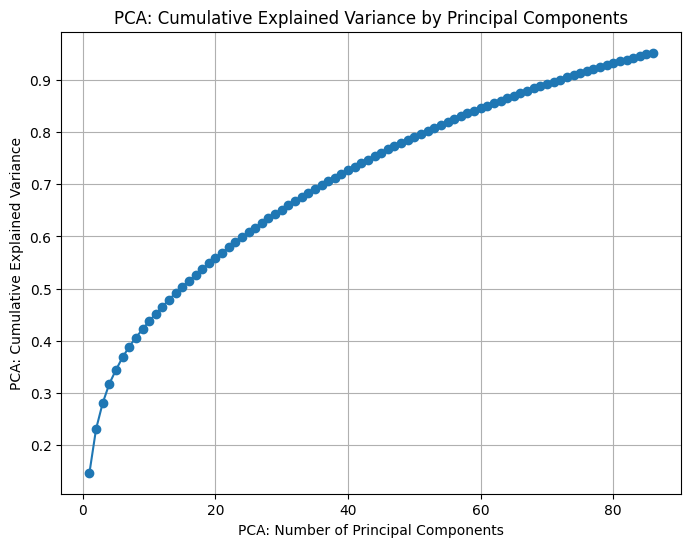

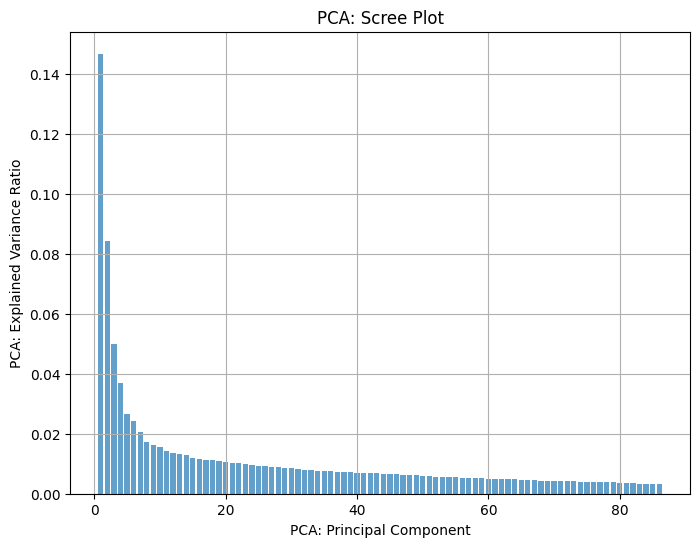

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pathlib import Path

# Load data
root = Path.cwd().parents[1]
full = root / "data" / "raw" / "full_df_with_meta.csv"
full_df_with_meta = pd.read_csv(full)

# Make a new column called 'healthy' that is 1 if study_condition == control, 0 if study_condition is not control
full_df_with_meta['healthy'] = np.where(full_df_with_meta["study_condition"] == "control", 1, 0)

# Define all bacteria columns as containing the string "|"
bacteria_columns = [col for col in full_df_with_meta.columns if '|' in col]

# Split data into features (X) and target (y)
X = full_df_with_meta[bacteria_columns]
y = full_df_with_meta['healthy']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42)

# Identify the minority class in the training set
minority_class = y_train.value_counts().idxmin()
minority_count = y_train.value_counts().min()

# Separate the majority and minority classes
X_train_minority = X_train[y_train == minority_class]
y_train_minority = y_train[y_train == minority_class]

X_train_majority = X_train[y_train != minority_class]
y_train_majority = y_train[y_train != minority_class]

# Undersample the majority class
X_train_majority_downsampled = X_train_majority.sample(n=minority_count, random_state=42)
y_train_majority_downsampled = y_train_majority.sample(n=minority_count, random_state=42)

# Combine the downsampled majority class with the minority class
X_train_balanced = pd.concat([X_train_minority, X_train_majority_downsampled])
y_train_balanced = pd.concat([y_train_minority, y_train_majority_downsampled])

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train_balanced.columns if '|' in col]
columns_sums = X_train_balanced[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train_balanced + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Perform PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_filtered)
X_val_pca = pca.transform(X_val_filtered)
X_test_pca = pca.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA: Scree Plot')
plt.grid(True)
plt.show()

# Save the PCA-transformed data
datasets = {
    'Training set': (X_train_pca, y_train_balanced), 
    'Validation set': (X_val_pca, y_val), 
    'Test set': (X_test_pca, y_test)
}
output_dir = root / 'data' / 'backup_undersampled'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, (X, y) in datasets.items():
        proportion = y.value_counts(normalize=True)
        total = len(y)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

# Save CSV files with the specified names
csv_names = ['train.csv', 'val.csv', 'test.csv']
for (X, y), csv_name in zip(datasets.values(), csv_names):
    combined_data = pd.concat([pd.DataFrame(X), y.reset_index(drop=True)], axis=1)
    combined_data.to_csv(output_dir / csv_name, index=False)


In [29]:
train = pd.read_csv("/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/data/backup_undersampled/train.csv") 
val = pd.read_csv("/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/data/backup_undersampled/val.csv")
test = pd.read_csv("/Users/emmaolsen/Desktop/datsci_backup_23/MB-LM-24/data/backup_undersampled/test.csv")

# count the number of 1s and 0s in the 'healthy' column in the training set
print(train['healthy'].value_counts()) 
print(val['healthy'].value_counts())
print(test['healthy'].value_counts())

healthy
0    1835
1    1835
Name: count, dtype: int64
healthy
1    827
0    413
Name: count, dtype: int64
healthy
1    847
0    393
Name: count, dtype: int64


# 0. Demographic the baseline data (with one-hot encoded categorical variables)

In [137]:
### TRYING TO DROP NA VALUES
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# load data
root = Path.cwd().parents[1]
baseline_file_path = root / "data" / "raw" / "healthy_subset_df_with_meta.csv"
demographic_data = pd.read_csv(baseline_file_path)

# calculate lactosum and create binary target variable 
lacto_columns = [col for col in demographic_data.columns if 'lactobacillus' in col.lower()]
demographic_data['LactoSum'] = demographic_data[lacto_columns].sum(axis=1)
demographic_data['Lacto_Binary'] = np.where(demographic_data['LactoSum'] > 0.01, 1, 0).astype(int)

# keep only columns containing the string 'Lacto_Binary' or columns that don't contain the string '|'
cols_to_keep = [col for col in demographic_data.columns if 'Lacto_Binary' in col or '|' not in col]
demographic_data = demographic_data[cols_to_keep]

# print values of Lacto_Binary to check, it should be 2776/2726
print(demographic_data['Lacto_Binary'].value_counts())

# drop LactoSum column
demographic_data = demographic_data.drop(columns=['LactoSum'])

# save the cleaned data 
demographic_data.to_csv(root / "data" / "baseline_demographic" / "healthy_subset_df_with_meta_lactobinary.csv", index=False)

# ---- Partition data 
selected_variables = [
    'age', 'gender', 'country', 'BMI', 'diet', 'smoker', 'alcohol'
]

# drop all columns that are not 'Lacto_Binary' or in the selected_variables list
demographic_data = demographic_data[[col for col in demographic_data.columns if 'Lacto_Binary' in col or col in selected_variables]]

# One-hot encode categorical variables with 0/1 encoding
categorical_vars = ['gender', 'country', 'diet', 'smoker', 'alcohol']
demographic_data = pd.get_dummies(demographic_data, columns=categorical_vars, drop_first=True, dtype=int)

# Update selected_variables after one-hot encoding
encoded_variables = list(demographic_data.columns)
selected_variables = [var for var in encoded_variables if any(orig_var in var for orig_var in ['age', 'BMI', 'gender', 'country', 'diet', 'smoker', 'alcohol'])]

# Drop rows with any NaN values
demographic_data = demographic_data.dropna()

# split data into features (X) and target (y)
X = demographic_data[selected_variables]
y = demographic_data['Lacto_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, # 15% of data is reserved for testing
                                                    random_state=42)

# further splitting the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, # X_train is further split into X_train and X_val
                                                  y_train, # y_train is further split into y_train and y_val
                                                  test_size=X_test.shape[0] / X_train.shape[0],  # 15% of the training set is reserved for validation
                                                  random_state=42)

datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test} # create a dictionary with the datasets



# Save the transformed data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'baseline_demographic'
output_dir.mkdir(parents=True, exist_ok=True)

# open a file to write
with open(output_dir, 'dataset_distribution.txt', 'w') as file:
    # print table headers and write to file
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    print(header)
    file.write(header + '\n')
    
    # loop through each dataset, print proportions and total counts, and write to file
    for name, dataset in datasets.items():
        proportion = pd.Series(dataset).value_counts(normalize=True)
        total = len(dataset)  # total number of observations
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        print(line)
        file.write(line + '\n')

for x, y, name in zip([X_train, X_val, X_test], 
                      [y_train, y_val, y_test], 
                      ['train', 'val', 'test']):
    combined_data = np.hstack([x, y.values.reshape(-1, 1)]) # combine X and y for each dataset 
    column_names = list(X.columns) + ['Lacto_Binary'] # construct list of column names, add Lacto_Binary to make sure it is the last column 
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir, f'{name}.csv', index=False)


/var/folders/98/18p7fygn5473lcp5yfrz9s340000gn/T/ipykernel_73246/1362952830.py:10: DtypeWarning: Columns (20,21,22,25,26,28,29,30,31,32,34,37,45,46,47,48,49,50,55,56,57,58,60,72,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  demographic_data = pd.read_csv(baseline_file_path)


Lacto_Binary
0    2776
1    2726
Name: count, dtype: int64


TypeError: 'str' object cannot be interpreted as an integer

In [110]:
# count how many rows in X_train has at least one 'NaN' value. 
nan_train = X_train.isnull().any(axis=1).sum()
print(f'Number of rows in X_train with at least one NaN value: {nan_train}')

nan_val = X_val.isnull().any(axis=1).sum()
print(f'Number of rows in X_val with at least one NaN value: {nan_val}')

nan_test = X_test.isnull().any(axis=1).sum()
print(f'Number of rows in X_test with at least one NaN value: {nan_test}')

print("-----------------------------------------------------------------------")
# print total number of rows in each dataset
print(f'Total number of rows in X_train: {X_train.shape[0]}')
print(f'Total number of rows in X_val: {X_val.shape[0]}')
print(f'Total number of rows in X_test: {X_test.shape[0]}')


print("-----------------------------------------------------------------------")
# The number of rows left in each dataset if I remove rows with at least one NaN value
left_train = X_train.dropna().shape[0]
left_val = X_val.dropna().shape[0]
left_test = X_test.dropna().shape[0]

print(f'Number of rows left in X_train if I remove rows with at least one NaN value: {left_train}')
print(f'Number of rows left in X_val if I remove rows with at least one NaN value: {left_val}')
print(f'Number of rows left in X_test if I remove rows with at least one NaN value: {left_test}')

Number of rows in X_train with at least one NaN value: 0
Number of rows in X_val with at least one NaN value: 0
Number of rows in X_test with at least one NaN value: 0
-----------------------------------------------------------------------
Total number of rows in X_train: 3168
Total number of rows in X_val: 680
Total number of rows in X_test: 680
-----------------------------------------------------------------------
Number of rows left in X_train if I remove rows with at least one NaN value: 3168
Number of rows left in X_val if I remove rows with at least one NaN value: 680
Number of rows left in X_test if I remove rows with at least one NaN value: 680


# 1. CLR non-reduced

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
from skbio.stats.composition import clr

# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path, index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Save the transformed data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'CLR_nonreduced'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = dataset.value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x_clr_df, y, name in zip([X_train_clr_df, X_val_clr_df, X_test_clr_df], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x_clr_df, y.values.reshape(-1, 1)])
    column_names = list(X_train.columns) + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)

print(f'Number of columns in X_train_df: {X_train_clr_df.shape[1]}')


Number of columns in X_train_df: 1478


# 2. Make CLR transformed data reduced

In [112]:
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

In [113]:
# select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])
# replace zeros with NaN to exclude them from the min calculation
numeric_data = numeric_data.replace(0, np.nan)
# find the smallest non-zero (non-NaN) value
min_non_zero_value = numeric_data.min().min()
print("The smallest non-zero value in the dataset is:", min_non_zero_value) # 3*10^-5 = 0.00003

The smallest non-zero value in the dataset is: 3e-05


In [114]:
# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Save the transformed data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'CLR'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = dataset.value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x_clr_filtered, y, name in zip([X_train_filtered, X_val_filtered, X_test_filtered], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x_clr_filtered, y.values.reshape(-1, 1)])
    column_names = list(filtered_columns) + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)

print(f'Number of columns in X_train_df: {X_train_filtered.shape[1]}')


Number of columns in X_train_df: 111


# 3. CLR+PCA transformed data

Number of columns in X_train_df: 111
Cumulative explained variance is: [0.13096284 0.23497862 0.28646585 0.31878991 0.34632049 0.36723047
 0.38510652 0.40090437 0.4160221  0.43002377 0.44382067 0.45727481
 0.47023472 0.48281718 0.49448183 0.5060331  0.51738309 0.52845409
 0.53921663 0.54974182 0.55996086 0.57003394 0.57994153 0.58970023
 0.59942832 0.60906688 0.61829329 0.62745402 0.63637054 0.64500522
 0.65353648 0.66184122 0.66999089 0.67805713 0.68590674 0.69352732
 0.70113755 0.70865397 0.71606241 0.72332656 0.73037665 0.73741098
 0.74429503 0.75116645 0.75788689 0.76454654 0.77099734 0.77734229
 0.78353538 0.78959361 0.79551016 0.80125952 0.80691596 0.81254599
 0.81800271 0.82343863 0.82878448 0.83396875 0.83911453 0.84412539
 0.84913028 0.85397951 0.85879622 0.86353304 0.86816631 0.87271534
 0.87717649 0.8816318  0.88594006 0.89020227 0.89441851 0.89853867
 0.90262908 0.90665886 0.91063672 0.91449762 0.91833743 0.92212185
 0.9257531  0.92937206 0.93286459 0.9362411  0.93959798 0.

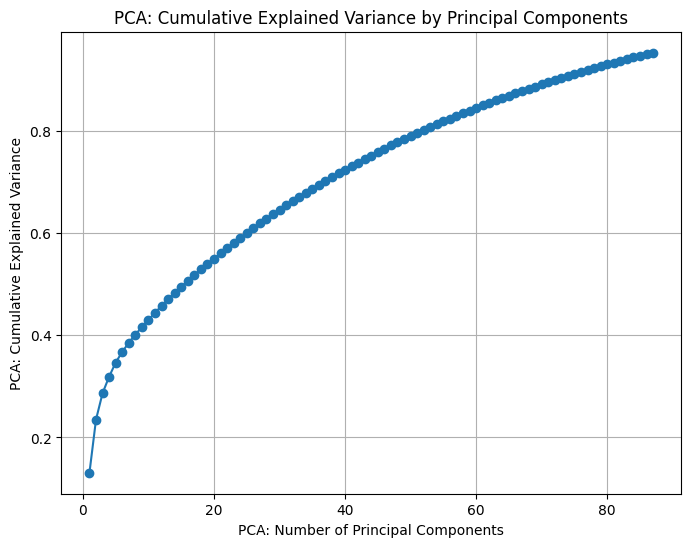

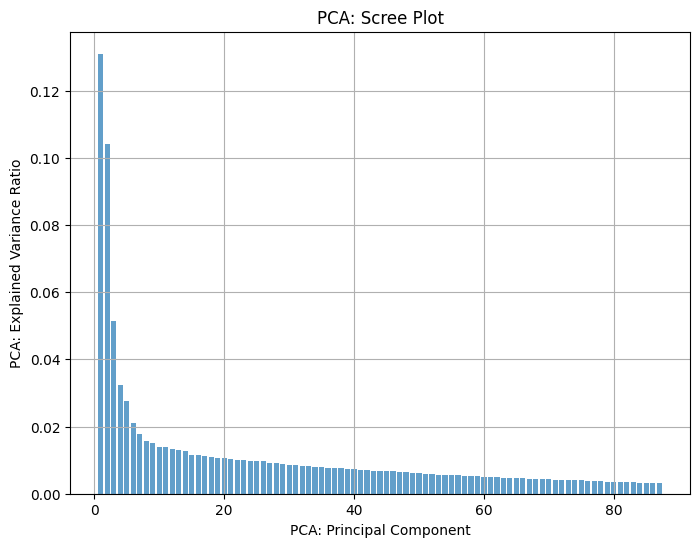

Number of columns in X_train_df: 87


In [115]:
# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# print number of columns in X_train_df
print(f'Number of columns in X_train_df: {X_train_filtered.shape[1]}')

# Perform PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_filtered)
X_val_pca = pca.transform(X_val_filtered)
X_test_pca = pca.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA: Scree Plot')
plt.grid(True)
plt.show()

# Save the transformed data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'CLR_PCA'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = dataset.value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x_pca, y, name in zip([X_train_pca, X_val_pca, X_test_pca], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x_pca, y.values.reshape(-1, 1)])
    column_names = [f'PC{i+1}' for i in range(x_pca.shape[1])] + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)

print(f'Number of columns in X_train_df: {X_train_pca.shape[1]}')

# 4. CLR + SVD transformed data

Cumulative explained variance is: [0.10055563 0.21339699 0.26556553 0.30825965 0.33629798 0.36000632
 0.38000365 0.39602414 0.41128508 0.42557393 0.43956494 0.45302382
 0.46603862 0.47871802 0.4909647  0.50251619 0.51386631 0.52506372
 0.53585685 0.54647757 0.55700269 0.56722168 0.57727117 0.5870791
 0.59681068 0.60650954 0.61573892 0.62491791 0.63393089 0.6426294
 0.65116322 0.6594708  0.66769577 0.67576244 0.68378844 0.69153786
 0.69915836 0.70671161 0.71415026 0.7214151  0.72855977 0.7356098
 0.74263076 0.74950238 0.75630564 0.76298499 0.76943958 0.77578903
 0.78199406 0.7880943  0.79405902 0.79995551 0.80566304 0.81129869
 0.81686859 0.82231592 0.82766785 0.83285843 0.83801378 0.84307583
 0.84808534 0.85294392 0.85776886 0.86251751 0.86715932 0.87171632
 0.87617696 0.88063247 0.8849705  0.88923606 0.89345791 0.8975782
 0.90167154 0.90570278 0.90970313 0.9136794  0.91753197 0.92133245
 0.92499135 0.92860916 0.93213395 0.93551878 0.93889199 0.94217899
 0.94536272 0.94850604 0.9516269

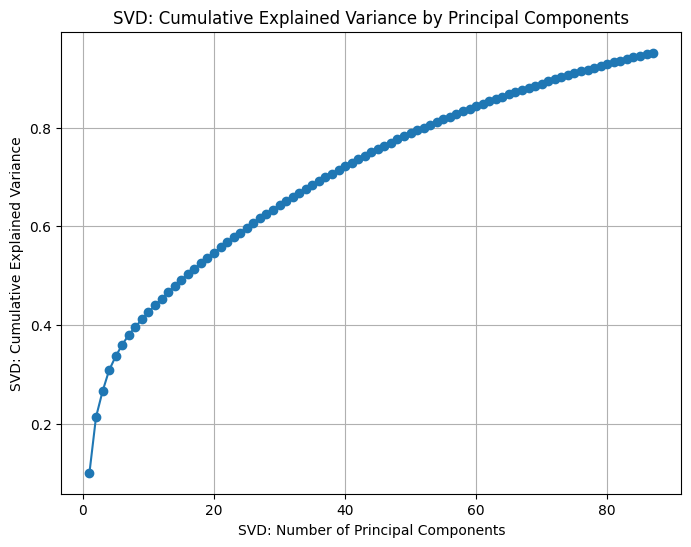

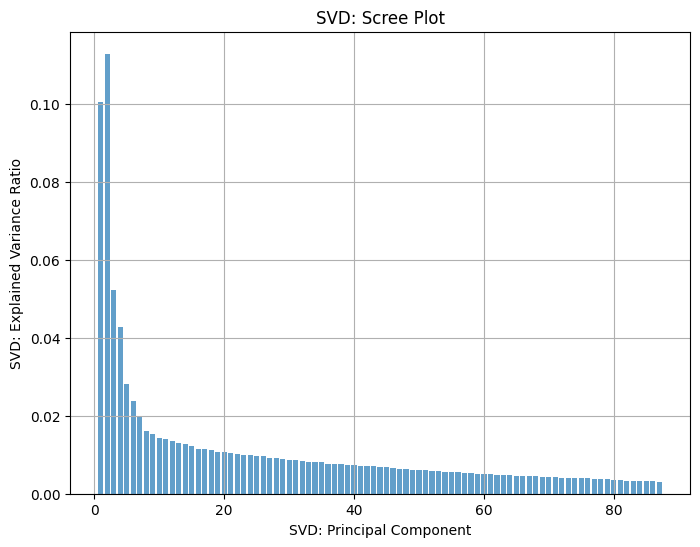

In [116]:
# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Apply pseudocount to avoid zeros
pseudocount = 1e-6
X_train_pseudocount = X_train + pseudocount
X_val_pseudocount = X_val + pseudocount
X_test_pseudocount = X_test + pseudocount

# Apply CLR transformation
X_train_clr = clr(X_train_pseudocount)
X_val_clr = clr(X_val_pseudocount)
X_test_clr = clr(X_test_pseudocount)

# Convert back to pandas DataFrame
X_train_clr_df = pd.DataFrame(X_train_clr, columns=X_train.columns)
X_val_clr_df = pd.DataFrame(X_val_clr, columns=X_val.columns)
X_test_clr_df = pd.DataFrame(X_test_clr, columns=X_test.columns)

# Filter X_train_clr_df, X_val_clr_df, and X_test_clr_df to include only the relevant columns
X_train_filtered = X_train_clr_df[filtered_columns]
X_val_filtered = X_val_clr_df[filtered_columns]
X_test_filtered = X_test_clr_df[filtered_columns]

# Perform SVD
svd = TruncatedSVD(n_components=87)
X_train_svd = svd.fit_transform(X_train_filtered)
X_val_svd = svd.transform(X_val_filtered)
X_test_svd = svd.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('SVD: Number of Principal Components')
plt.ylabel('SVD: Cumulative Explained Variance')
plt.title('SVD: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(svd.explained_variance_ratio_) + 1), svd.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('SVD: Principal Component')
plt.ylabel('SVD: Explained Variance Ratio')
plt.title('SVD: Scree Plot')
plt.grid(True)
plt.show()

# Save the transformed data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'CLR_SVD'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = dataset.value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x_svd, y, name in zip([X_train_svd, X_val_svd, X_test_svd], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x_svd, y.values.reshape(-1, 1)])
    column_names = [f'SVD{i+1}' for i in range(x_svd.shape[1])] + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)


# 5. Reduced_0_1 data

In [117]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before CLR
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is 0.1% or more
filtered_columns = columns_percentages[columns_percentages >= 0.1].index

# Filter X_train, X_val, and X_test to include only the relevant columns
X_train_filtered = X_train[filtered_columns]
X_val_filtered = X_val[filtered_columns]
X_test_filtered = X_test[filtered_columns]

# Save the filtered data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'reduced_0_1'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = pd.Series(dataset).value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x, y, name in zip([X_train_filtered, X_val_filtered, X_test_filtered], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x, y.values.reshape(-1, 1)])
    column_names = list(x.columns) + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)

X_train_filtered


,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_vulgatus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Acidaminococcales|f__Acidaminococcaceae|g__Acidaminococcus|s__Acidaminococcus_intestini,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium|s__Eubacterium_sp_CAG_38,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Tannerellaceae|g__Parabacteroides|s__Parabacteroides_distasonis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_faecis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Eubacterium_rectale,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_uniformis,k__Bacteria|p__Proteobacteria|c__Proteobacteria_unclassified|o__Proteobacteria_unclassified|f__Proteobacteria_unclassified|g__Proteobacteria_unclassified|s__Proteobacteria_bacterium_CAG_139,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Fusicatenibacter|s__Fusicatenibacter_saccharivorans,...,k__Bacteria|p__Firmicutes|c__Tissierellia|o__Tissierellales|f__Peptoniphilaceae|g__Finegoldia|s__Finegoldia_magna,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_5226,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_520,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_AM42_24,k__Bacteria|p__Firmicutes|c__Firmicutes_unclassified|o__Firmicutes_unclassified|f__Firmicutes_unclassified|g__Firmicutes_unclassified|s__Firmicutes_bacterium_CAG_791,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio|s__Butyrivibrio_sp_CAG_318,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_sp_CAG_510,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_885,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella|s__Prevotella_sp_CAG_873,k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Cupriavidus|s__Cupriavidus_metallidurans
5397,8.24664,0.00000,0.00000,2.38427,0.66982,3.90045,1.17884,1.98623,0.05569,2.77321,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
1481,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.88784,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,2.1583,0.0,0.06515,5.60659,0.0,0.0,0.0
3332,0.07740,0.00000,0.66214,0.00000,0.01349,2.45554,1.66592,0.50034,0.00000,1.38702,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
5205,10.15352,3.30632,2.07798,0.00000,6.69045,0.00925,0.30159,4.41818,0.00000,0.93809,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
3125,2.84287,0.00000,0.00000,0.00082,0.33308,0.51714,19.68795,3.45035,0.00000,7.04566,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,0.01249,0.02414,0.00000,0.00159,1.84705,0.13032,0.47199,4.72059,0.00000,2.15406,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
1790,5.19014,0.00000,0.00000,1.19699,0.56392,0.00012,2.07675,6.04774,0.00000,1.44070,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
317,13.61216,0.00000,0.00000,2.42765,1.89845,10.00183,10.66560,8.06453,0.03840,4.19874,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0
993,8.69529,0.00000,0.00000,0.90466,0.81987,6.07346,8.14013,8.19355,0.00000,4.17571,...,0.0,0.0,0.0,0.0000,0.0,0.00000,0.00000,0.0,0.0,0.0


# 76. Reduced_0_1 + PCA 
I do this because the data is very sparse and has a lot of features. I want to reduce the number of features to make the model more interpretable and to reduce the risk of overfitting.
I do this by first thresholding the data and then applying PCA. PCA decrease the number of features by selecting dimension of features which have most of the variance. Data is still on the same scale and sum to 1, and therefore I have chosen not to scale the data before applying PCA. 


[0.31394337 0.09736937 0.05340137 0.04002439 0.03690475 0.03289054
 0.02757451 0.02682614 0.02580687 0.0253191  0.02033511 0.0185012
 0.01578151 0.01489137 0.01443746 0.01314689 0.0118043  0.01060561
 0.0100321  0.00947034 0.00894086 0.00768696 0.00689198 0.00635301
 0.00594022 0.00579722 0.00557407 0.0054337  0.00538579 0.00514789
 0.00483737 0.00469292 0.00460693 0.00438078 0.0042982  0.00405518
 0.00377863 0.00366656 0.0034887  0.00335672 0.00316671 0.00305937
 0.00293087 0.00278919 0.0026538  0.00258935 0.00247098 0.00231877
 0.00213523 0.00206572 0.00201273]
Cumulative explained variance is: [0.31394337 0.41131274 0.46471411 0.5047385  0.54164325 0.57453379
 0.6021083  0.62893443 0.6547413  0.6800604  0.70039552 0.71889672
 0.73467822 0.74956959 0.76400706 0.77715395 0.78895825 0.79956386
 0.80959596 0.81906631 0.82800717 0.83569413 0.84258612 0.84893912
 0.85487935 0.86067657 0.86625063 0.87168434 0.87707013 0.88221802
 0.88705539 0.89174831 0.89635523 0.90073601 0.90503421 0.909

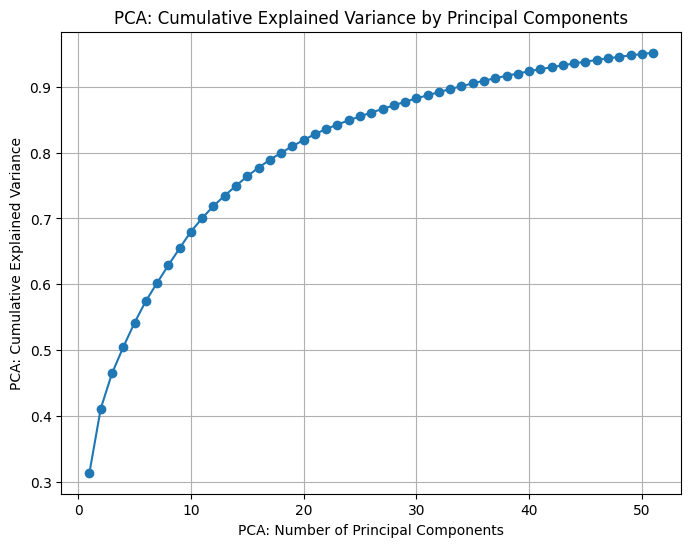

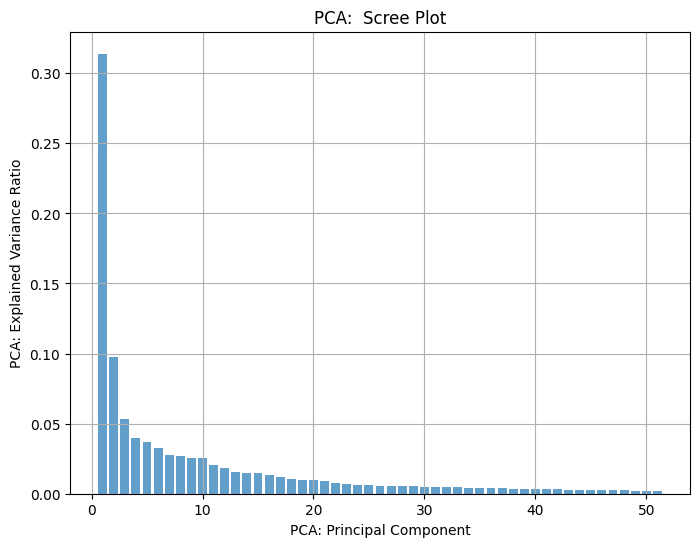

Number of columns in X_train_df: 51


In [118]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before thresholding
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is greater than 0.1%
filtered_columns = columns_percentages[columns_percentages > 0.1].index

# Filter X_train, X_val, and X_test to include only the relevant columns
X_train_filtered = X_train[filtered_columns]
X_val_filtered = X_val[filtered_columns]
X_test_filtered = X_test[filtered_columns]

# Perform PCA on the filtered data
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_filtered)
print(pca.explained_variance_ratio_)

# Project the validation and test sets onto the PCA space generated from the training data
X_val_pca = pca.transform(X_val_filtered)
X_test_pca = pca.transform(X_test_filtered)


# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('PCA: Number of Principal Components')
plt.ylabel('PCA: Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('PCA: Principal Component')
plt.ylabel('PCA: Explained Variance Ratio')
plt.title('PCA:  Scree Plot')
plt.grid(True)
plt.show()

# Save the thresholded data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'reduced_0_1_PCA'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = pd.Series(dataset).value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x_pca, y, name in zip([X_train_pca, X_val_pca, X_test_pca], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x_pca, y.values.reshape(-1, 1)])
    column_names = [f'PC{i+1}' for i in range(x_pca.shape[1])] + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)
    
# print number of columns in X_train_df
print(f'Number of columns in X_train_df: {X_train_pca.shape[1]}')

# 8. Reduced_0_1 + SVD

[0.24562669 0.09070127 0.0926026  0.05162535 0.03997537 0.03354777
 0.03274372 0.02753819 0.02651421 0.02563474 0.02381759 0.01966627
 0.01604165 0.01568765 0.01480794 0.01314727 0.01176926 0.01175136
 0.01003212 0.01002356 0.00927192 0.00855919 0.00703542 0.00680672
 0.00598733 0.00579723 0.00560943 0.00550528 0.00542796 0.00535645
 0.00509372 0.00478313 0.00466312 0.00460318 0.00437856 0.00429203
 0.00404654 0.00371523 0.00353855 0.00346886 0.00334448 0.00311584
 0.0030582  0.00293065 0.00278719 0.00263228 0.00255335 0.00241445
 0.00220975 0.00211534 0.00204936]
Cumulative explained variance is: [0.24562669 0.33632796 0.42893055 0.4805559  0.52053127 0.55407904
 0.58682276 0.61436095 0.64087516 0.66650991 0.6903275  0.70999377
 0.72603542 0.74172307 0.75653101 0.76967827 0.78144753 0.79319889
 0.80323101 0.81325457 0.82252649 0.83108568 0.8381211  0.84492782
 0.85091515 0.85671238 0.86232181 0.86782708 0.87325504 0.87861149
 0.88370521 0.88848834 0.89315146 0.89775463 0.90213319 0.90

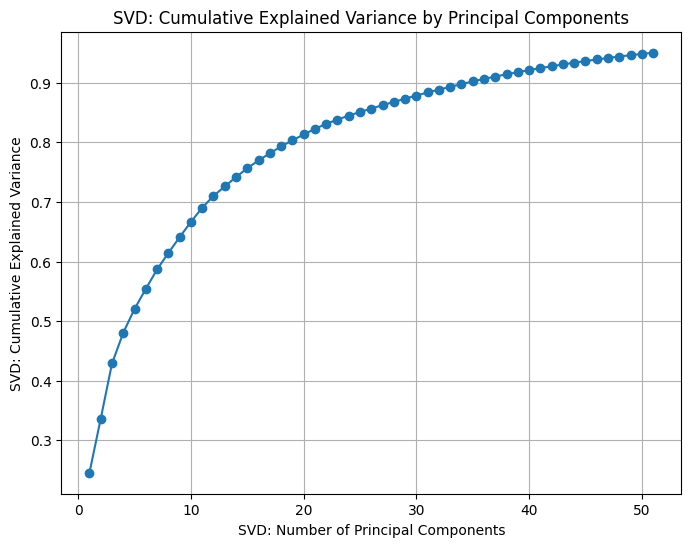

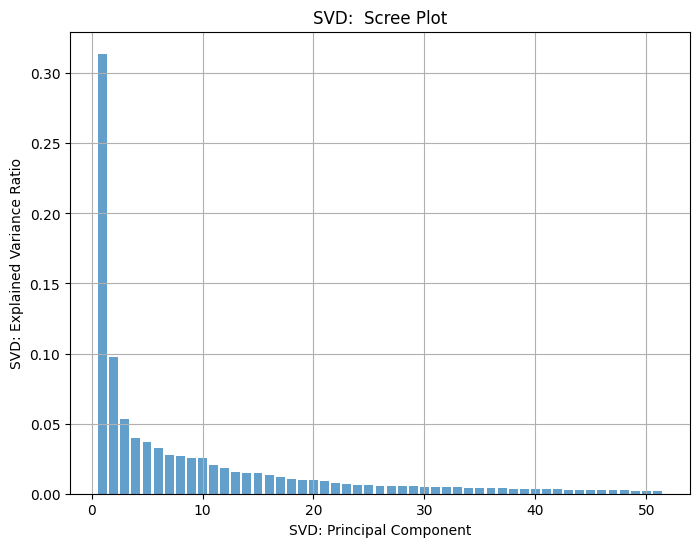

In [119]:
# Load data
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)

# Identify Lactobacillus columns and compute binary label
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int)

# Drop the LactoSum column
data = data.drop(columns=['LactoSum'])

# Partition data into features (X) and target (y)
X = data.drop(columns=['sample_id', 'Lacto_Binary'])
y = data['Lacto_Binary']

# Split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=X_test.shape[0] / X_train.shape[0],  
                                                  random_state=42)

# Calculate the sum for each column before thresholding
species_columns = [col for col in X_train.columns if '|' in col]
columns_sums = X_train[species_columns].sum()
total_sum = columns_sums.sum()
columns_percentages = (columns_sums / total_sum) * 100

# Find columns where percentage is greater than 0.1%
filtered_columns = columns_percentages[columns_percentages > 0.1].index

# Filter X_train, X_val, and X_test to include only the relevant columns
X_train_filtered = X_train[filtered_columns]
X_val_filtered = X_val[filtered_columns]
X_test_filtered = X_test[filtered_columns]

# Perform SVD on the filtered data
svd = TruncatedSVD(n_components=51, random_state=42)
X_train_svd = svd.fit_transform(X_train_filtered)
print(svd.explained_variance_ratio_)

# Project the validation and test sets onto the SVD space generated from the training data
X_val_svd = svd.transform(X_val_filtered)
X_test_svd = svd.transform(X_test_filtered)

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)
print(f"Cumulative explained variance is: {cumulative_explained_variance}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('SVD: Number of Principal Components')
plt.ylabel('SVD: Cumulative Explained Variance')
plt.title('SVD: Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Scree plot of explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7, align='center')
plt.xlabel('SVD: Principal Component')
plt.ylabel('SVD: Explained Variance Ratio')
plt.title('SVD:  Scree Plot')
plt.grid(True)
plt.show()



# Save the thresholded data
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test}
output_dir = root / 'data' / 'reduced_0_1_SVD'
output_dir.mkdir(parents=True, exist_ok=True)

with open(output_dir / 'dataset_distribution.txt', 'w') as file:
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    file.write(header + '\n')
    
    for name, dataset in datasets.items():
        proportion = pd.Series(dataset).value_counts(normalize=True)
        total = len(dataset)
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        file.write(line + '\n')

for x_svd, y, name in zip([X_train_svd, X_val_svd, X_test_svd], [y_train, y_val, y_test], ['train', 'val', 'test']):
    combined_data = np.hstack([x_svd, y.values.reshape(-1, 1)])
    column_names = [f'SVD{i+1}' for i in range(x_svd.shape[1])] + ['Lacto_Binary']
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(output_dir / f'{name}.csv', index=False)


# 9. Not-thresholded data

In [66]:
root = Path.cwd().parents[1]
data_path = root / "data" / "raw" / "healthy_subset_df.csv"
data = pd.read_csv(data_path,index_col=0)
lacto_columns = [col for col in data.columns if 'lactobacillus' in col.lower()]
data['LactoSum'] = data[lacto_columns].sum(axis=1)
data['Lacto_Binary'] = np.where(data['LactoSum'] > 0.01, 1, 0).astype(int) # astype(int) converts True/False to 1/0 
# drop the LactoSum column
data = data.drop(columns=['LactoSum'])


# ------------- PARTITION TEMPORARY DATA (BEFORE THRESHOLDING)
X = data.drop(columns=['sample_id','Lacto_Binary'])
y = data['Lacto_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15, # 15% of data is reserved for testing
                                                    random_state=42)

# further splitting the training set into a training and a validation set (15%)
X_train, X_val, y_train, y_val = train_test_split(X_train, # X_train is further split into X_train and X_val
                                                  y_train, # y_train is further split into y_train and y_val
                                                  test_size=X_test.shape[0] / X_train.shape[0],  # 15% of the training set is reserved for validation
                                                  random_state=42)



# ------ SAVE THE TRHESHOLDED DATA ------ # 
datasets = {'Training set': y_train, 'Validation set': y_val, 'Test set': y_test} # create a dictionary with the datasets

# open a file to write
with open('../../data/non_reduced/dataset_distribution.txt', 'w') as file:
    # print table headers and write to file
    header = "{:<15} | {:>4} | {:>4} | {:>7}".format("Dataset", "1", "0", "Rows")
    print(header)
    file.write(header + '\n')
    
    # loop through each dataset, print proportions and total counts, and write to file
    for name, dataset in datasets.items():
        proportion = pd.Series(dataset).value_counts(normalize=True)
        total = len(dataset)  # total number of observation
        proportion_1 = proportion.get(1, 0)
        proportion_0 = proportion.get(0, 0)
        line = "{:<15} | {:.2f} | {:.2f} | {:>7}".format(name, proportion_1, proportion_0, total)
        print(line)
        file.write(line + '\n')


for x, y, name in zip([X_train, X_val, X_test], 
                      [y_train, y_val, y_test], 
                      ['train', 'val', 'test']):
    combined_data = np.hstack([x, y.values.reshape(-1, 1)]) # combine X and y for each dataset 
    column_names = list(X.columns) + ['Lacto_Binary'] # construct list of column names, add Lacto_Binary to make sure it is the last column 
    df = pd.DataFrame(combined_data, columns=column_names)
    df.to_csv(f'../../data/non_reduced/{name}.csv', index=False)


Dataset         |    1 |    0 |    Rows
Training set    | 0.50 | 0.50 |    3850
Validation set  | 0.51 | 0.49 |     826
Test set        | 0.48 | 0.52 |     826
